
# 
# This notebook implements a Physics-Informed Neural Network (PINN) for classifying gravitational lensing images. The architecture incorporates physical principles of gravitational lensing to improve classification performance.
# 
# ## Table of Contents
# 1. [Setup and Imports](#setup)
# 2. [Data Loading and Preprocessing](#data)
# 3. [Model Architecture](#model)
# 4. [Training](#training)
# 5. [Evaluation and Results Analysis](#evaluation)
# 
# ## 1. Setup and Imports <a name="setup"></a>

In [15]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm # Changed from tqdm.notebook
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, models

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Exploring dataset structure:
Class: no_sub, Samples: 29449
  First sample path: multi_class/Dataset\no_sub\no_sub_sim_100007394254046077438189589177507789788.npy
  First sample shape: (64, 64)
  First sample data type: <class 'numpy.ndarray'>
--------------------------------------------------
Class: cdm, Samples: 29759
  First sample path: multi_class/Dataset\cdm\cdm_sim_100018885569244704564890691631658381792.npy
  First sample shape: (64, 64)
  First sample data type: <class 'numpy.ndarray'>
--------------------------------------------------
Class: axion, Samples: 29896
  First sample path: multi_class/Dataset\axion\axion_sim_100000344109220308579478752698140600138.npy
  First sample shape: (2,)
  First sample data type: <class 'numpy.ndarray'>
    Axion structure: First element shape: (64, 64)
    Axion structure: Second element type: <class 'numpy.float64'>
--------------------------------------------------


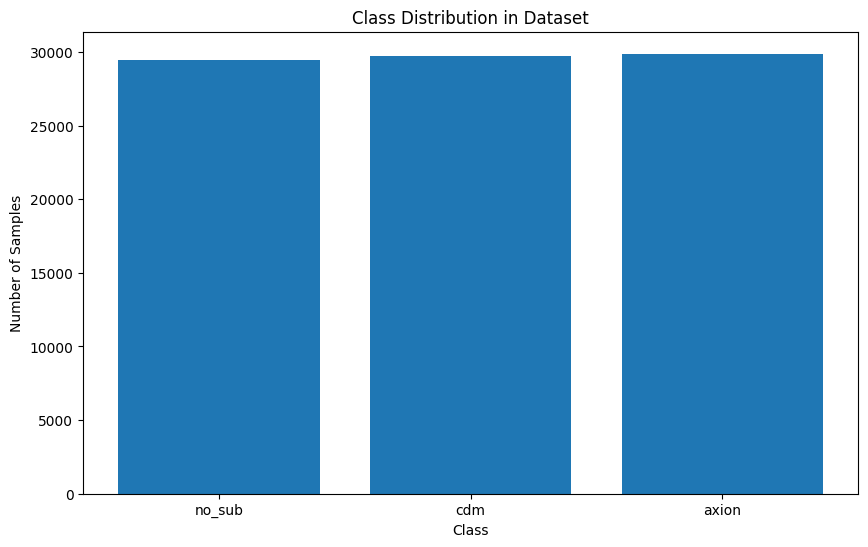

In [16]:
# Cell 2: Data Exploration
# Define class names and paths
class_dict = {
    0: "no_sub",  # No substructure
    1: "cdm",     # Subhalo substructure (CDM)
    2: "axion"    # Vortex substructure (Axion)
}

# Path to dataset - Make sure this path is correct for your environment
# Example: dataset_path = "path/to/your/multi_class/Dataset"
# If the notebook and the 'multi_class' folder are in the same directory:
dataset_path = "multi_class/Dataset"


# Function to load numpy arrays with pickle support
def load_sample(file_path):
    try:
        return np.load(file_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading sample {file_path}: {e}")
        return None

# Function to explore dataset structure
def explore_dataset(data_path, classes):
    dataset_stats = {}
    print("Exploring dataset structure:")
    all_classes_found = True
    for class_id, class_name in classes.items():
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            print(f"Error: Directory not found for class '{class_name}' at {class_path}")
            all_classes_found = False
            dataset_stats[class_name] = 0 # Record class as having 0 samples
            continue # Skip to the next class

        files = os.listdir(class_path)
        if not files:
             print(f"Warning: No files found for class '{class_name}' at {class_path}")
             dataset_stats[class_name] = 0
             continue # Skip to the next class

        dataset_stats[class_name] = len(files)

        # Load first sample to check shape
        first_file = os.path.join(class_path, files[0])
        sample = load_sample(first_file)

        if sample is not None:
            print(f"Class: {class_name}, Samples: {len(files)}")
            print(f"  First sample path: {first_file}") # Useful for debugging
            print(f"  First sample shape: {sample.shape}")
            print(f"  First sample data type: {type(sample)}")

            # Special handling for 'axion' structure if needed
            if isinstance(sample, np.ndarray) and len(sample.shape) == 1 and sample.shape[0] == 2 and class_name == 'axion':
                 if isinstance(sample[0], np.ndarray):
                     print(f"    Axion structure: First element shape: {sample[0].shape}")
                 else:
                     print(f"    Axion structure: First element type: {type(sample[0])} (Expected numpy array)")
                 print(f"    Axion structure: Second element type: {type(sample[1])}")
            elif not isinstance(sample, np.ndarray):
                 print(f"  Warning: Sample is not a numpy array, type: {type(sample)}")

        print("-" * 50)

    if not all_classes_found:
        print("\nWarning: Not all class directories were found. Check 'dataset_path' and folder structure.")
        print(f"Expected subfolders in '{data_path}': {list(classes.values())}")

    return dataset_stats

# --- Execution ---
# Check if dataset path exists before exploring
if not os.path.isdir(dataset_path):
    print(f"Error: The dataset path '{dataset_path}' does not exist or is not a directory.")
    print("Please ensure the 'multi_class/Dataset' folder is in the correct location relative to the notebook, or update the 'dataset_path' variable.")
    stats = {} # Set stats to empty to prevent plotting errors
else:
    stats = explore_dataset(dataset_path, class_dict)

    # Plot class distribution only if stats were successfully collected
    if stats and any(stats.values()): # Check if stats is not empty and has non-zero counts
        plt.figure(figsize=(10, 6))
        # Only plot classes with > 0 samples if some dirs were missing/empty
        valid_keys = [k for k, v in stats.items() if v > 0]
        valid_values = [stats[k] for k in valid_keys]
        if valid_keys:
            plt.bar(valid_keys, valid_values)
            plt.title('Class Distribution in Dataset')
            plt.xlabel('Class')
            plt.ylabel('Number of Samples')
            plt.show()
        else:
             print("No samples found in any class directory for plotting.")
    elif not stats:
         print("Could not generate class distribution plot as dataset exploration failed.")
    else:
        print("Could not generate class distribution plot as no samples were found.")

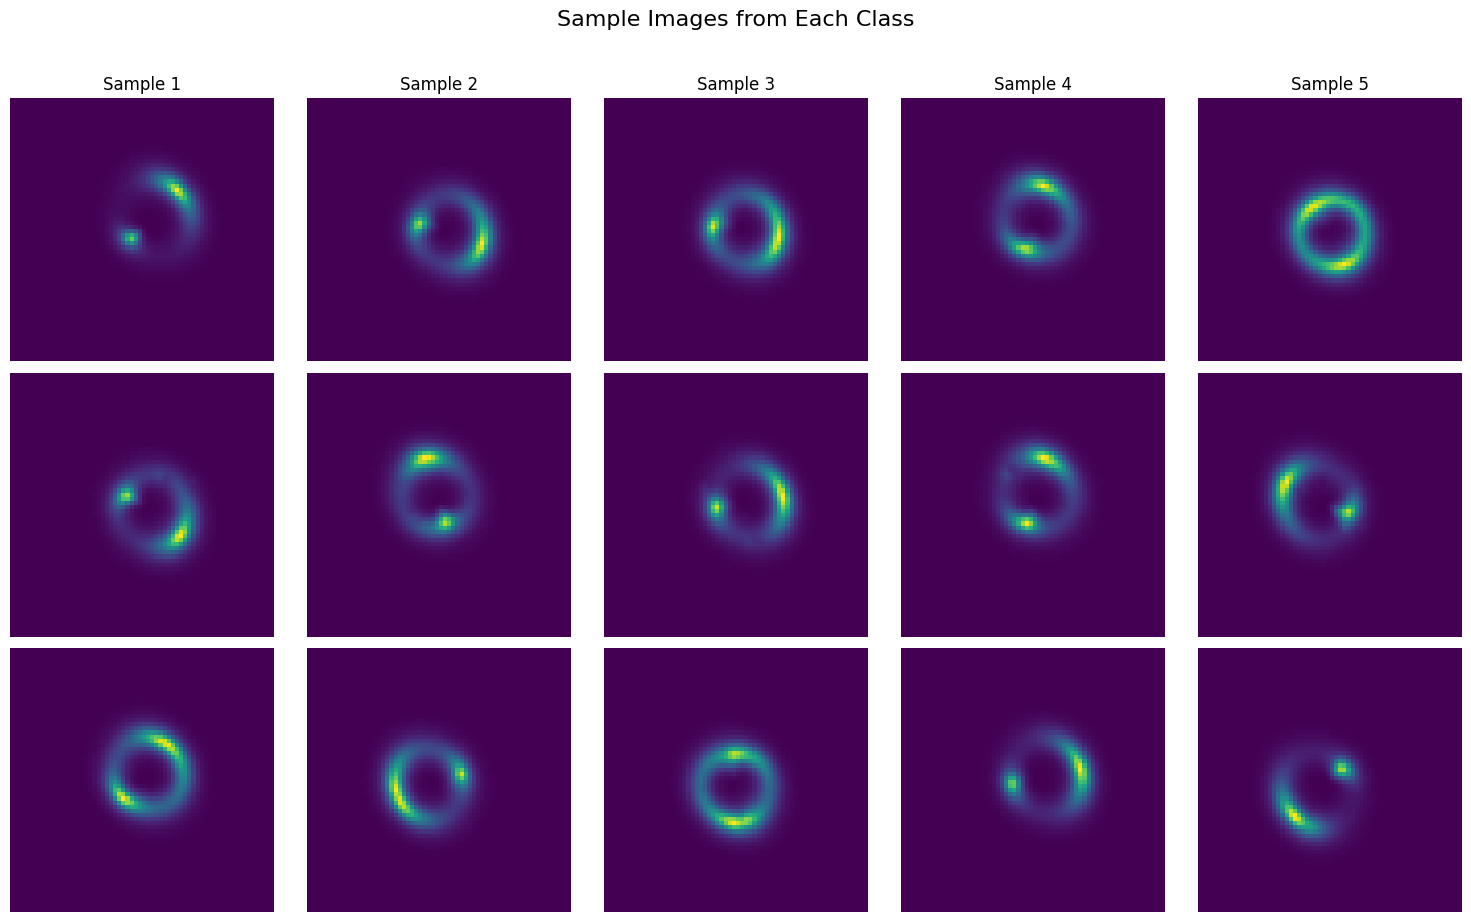

In [17]:
# Cell 3: Data Visualization
# Function to visualize samples
def visualize_samples(data_path, classes, num_samples=5):
    num_classes_found = 0
    class_paths = {}
    files_in_class = {}

    # Pre-check paths and file availability
    for class_id, class_name in classes.items():
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if f.endswith('.npy')] # Assuming .npy files
            if files:
                num_classes_found += 1
                class_paths[class_id] = class_path
                files_in_class[class_id] = files

    if num_classes_found == 0:
        print("No class directories with valid samples found for visualization.")
        return

    plt.figure(figsize=(max(15, num_samples * 3), num_classes_found * 3)) # Adjust size based on samples/classes
    plot_idx = 1

    for i, (class_id, class_name) in enumerate(classes.items()):
        if class_id not in class_paths: # Skip if class wasn't found earlier
            continue

        class_path = class_paths[class_id]
        files = files_in_class[class_id]

        # Select random samples, ensure num_samples doesn't exceed available files
        k = min(num_samples, len(files))
        if k == 0:
            print(f"No samples to visualize for class '{class_name}'")
            continue
        selected_files = random.sample(files, k)

        for j, file in enumerate(selected_files):
            file_path = os.path.join(class_path, file)
            try:
                sample = load_sample(file_path)
                if sample is None: continue # Skip if loading failed

                # Handle 'axion' structure
                image = None
                if isinstance(sample, np.ndarray) and len(sample.shape) == 1 and sample.shape[0] == 2 and class_name == 'axion':
                    if isinstance(sample[0], np.ndarray):
                        image = sample[0]
                    else:
                        print(f"Skipping axion sample {file}: first element is not an image array.")
                        continue
                elif isinstance(sample, np.ndarray):
                    image = sample
                else:
                    print(f"Skipping sample {file}: loaded data is not a numpy array.")
                    continue

                # Ensure image is 2D
                if image is not None and len(image.shape) != 2:
                    print(f"Skipping sample {file}: image is not 2D, shape {image.shape}")
                    continue
                elif image is None:
                    continue # Should not happen based on checks above, but safeguard

                # Determine subplot location dynamically
                plt.subplot(num_classes_found, num_samples, plot_idx)
                plt.imshow(image, cmap='viridis')
                plt.axis('off')

                # Add title only to the first row of plots for this class
                if j == 0: # Changed from i == 0 to j == 0 for column title logic
                    plt.ylabel(class_name, fontsize=12, rotation=0, labelpad=40, va='center')

                # Add sample number title only for the very first row of the entire grid
                is_first_class_row = (plot_idx <= num_samples) # Check if it's in the first logical row
                if is_first_class_row:
                    plt.title(f"Sample {j+1}")

                plot_idx += 1 # Increment plot index

            except Exception as e:
                print(f"Error processing sample {file_path}: {e}")

    if plot_idx > 1: # Only show if at least one plot was made
        plt.suptitle('Sample Images from Each Class', fontsize=16, y=1.02) # Adjust title position
        plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout slightly
        plt.show()
    else:
        print("No samples were successfully visualized.")


# Visualize samples from each class (run only if dataset_path is valid)
if os.path.isdir(dataset_path):
    visualize_samples(dataset_path, class_dict, 5)
else:
    print("Skipping visualization as dataset path is invalid.")

In [18]:
# Cell 4: Dataset Class and Transforms
class StrongLensingDataset(Dataset):
    """Custom Dataset for Strong Lensing images."""
    def __init__(self, samples, classes, transform=None):
        """
        Args:
            samples (list): A list of tuples (filepath, class_id).
            classes (dict): Dictionary mapping class_id to class_name.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        if not samples:
             raise ValueError("The 'samples' list provided to the dataset is empty.")
        self.samples = samples
        self.classes = classes
        self.transform = transform

        print(f"Dataset initialized with {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path, label = self.samples[idx]

        try:
            # Load sample
            sample = load_sample(file_path)
            if sample is None: # Handle potential loading error from load_sample
                raise IOError(f"Failed to load sample from {file_path}")

            image = None
            # Handle 'axion' structure specifically
            class_name = self.classes.get(label, "unknown") # Get class name for conditional logic
            if isinstance(sample, np.ndarray) and len(sample.shape) == 1 and sample.shape[0] == 2 and class_name == 'axion':
                if isinstance(sample[0], np.ndarray):
                     image = sample[0] # Extract the array part
                else:
                     raise ValueError(f"Axion sample format error in {file_path}: first element is not an array.")
            elif isinstance(sample, np.ndarray):
                image = sample  # For other classes or malformed axion
            else:
                 raise TypeError(f"Loaded sample from {file_path} is not a numpy array. Type: {type(sample)}")

            # Ensure the image is 2D
            if image.ndim != 2:
                 # Attempt to fix common extra dimensions (e.g., grayscale image saved with a channel dim)
                 if image.ndim == 3 and image.shape[0] == 1:
                     image = image.squeeze(0)
                 elif image.ndim == 3 and image.shape[2] == 1:
                      image = image.squeeze(2)
                 else:
                      raise ValueError(f"Expected 2D image from {file_path}, got shape {image.shape} after potential squeeze.")
            if image.ndim != 2: # Re-check after squeeze attempt
                 raise ValueError(f"Could not convert image from {file_path} to 2D, final shape {image.shape}")

            # Ensure image data type is appropriate (e.g., float)
            if not np.issubdtype(image.dtype, np.floating):
                 image = image.astype(np.float32)
            # Optional: Rescale if necessary, e.g., if data isn't roughly in [0,1] or [-1,1]
            # image = image / image.max() if image.max() > 0 else image

            # Convert to tensor and add channel dimension
            image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

            # Apply transforms if specified
            if self.transform:
                image_tensor = self.transform(image_tensor)

            return image_tensor, label

        except Exception as e:
            print(f"Error loading or processing item {idx} ({file_path}): {e}")
            # Decide error handling: skip, return dummy, or raise
            # Option 1: Re-raise the error (stops training iteration)
            raise e
            # Option 2: Return None or a dummy tensor (might hide issues)
            # return None, -1 # Or return a placeholder tensor/label


# Define data transformations
# Normalization values depend on dataset statistics. Using 0.5 mean/std is common
# if data is scaled to [-1, 1] or not scaled but symmetric around 0.
# If data is scaled [0,1], mean=0.5, std=0.5 is reasonable. If raw pixel values, calculate mean/std.
_mean_ = [0.5]
_std_ = [0.5]

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=_mean_, std=_std_) # Normalization should generally be last or after ToTensor
])

val_test_transform = transforms.Compose([
    transforms.Normalize(mean=_mean_, std=_std_)
])


Loading sample paths...
Total valid samples found: 89104

Creating datasets...
Dataset initialized with 71282 samples
Dataset initialized with 8911 samples
Dataset initialized with 8911 samples

Train set size: 71282
Validation set size: 8911
Test set size: 8911

Verifying a batch from train_loader:
Batch images shape: torch.Size([64, 1, 64, 64])
Batch labels shape: torch.Size([64])

Visualizing a batch from train_loader:
An unexpected error occurred during dataset/dataloader setup: Numpy is not available


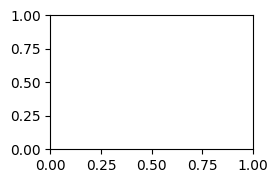

In [19]:
# Cell 5: Dataset Splitting and Dataloaders
# Create dataset splits (80:10:10 train-val-test split)
def create_datasets(data_path, classes, test_size=0.1, val_size=0.1, random_seed=42):
    all_samples = []
    print("\nLoading sample paths...")
    found_valid_class = False
    for class_id, class_name in classes.items():
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: Directory not found for class '{class_name}' at {class_path}")
            continue
        files = [f for f in os.listdir(class_path) if f.endswith('.npy')] # Check for .npy
        if not files:
            print(f"Warning: No .npy files found for class '{class_name}' at {class_path}")
            continue
        found_valid_class = True
        for file in files:
            file_path = os.path.join(class_path, file)
            all_samples.append((file_path, class_id))

    if not found_valid_class or not all_samples:
        raise ValueError("No valid samples (.npy files in existing class directories) were found.")

    print(f"Total valid samples found: {len(all_samples)}")
    labels = [label for _, label in all_samples]

    # Check if there are enough samples in each class for stratification
    unique_labels, counts = np.unique(labels, return_counts=True)
    min_samples_per_class = int(min(counts) * (1-test_size) * (1- val_size/(1-test_size)))
    if min_samples_per_class < 1 :
         print("Warning: Small number of samples per class might lead to issues with stratification.")
         # Decide how to handle this: maybe proceed without stratify, or raise error.
         # For now, proceed with stratification but be aware.

    # Split into train_val and test sets
    try:
        train_val_samples, test_samples = train_test_split(
            all_samples,
            test_size=test_size,
            stratify=labels,
            random_state=random_seed
        )
    except ValueError as e:
         print(f"Error during train/test split (possibly too few samples for stratification): {e}")
         print("Attempting split without stratification...")
         train_val_samples, test_samples = train_test_split(
            all_samples, test_size=test_size, random_state=random_seed
        )


    # Split train_val into train and validation sets
    train_val_labels = [label for _, label in train_val_samples]
    try:
         # Ensure val_size is calculated correctly for the remaining data
         relative_val_size = val_size / (1.0 - test_size)
         if relative_val_size >= 1.0 or relative_val_size <= 0.0:
              raise ValueError(f"Calculated relative validation size ({relative_val_size:.2f}) is invalid. Check test_size and val_size.")

         train_samples, val_samples = train_test_split(
            train_val_samples,
            test_size=relative_val_size,
            stratify=train_val_labels,
            random_state=random_seed
        )
    except ValueError as e:
        print(f"Error during train/validation split (possibly too few samples for stratification): {e}")
        print("Attempting split without stratification...")
        train_samples, val_samples = train_test_split(
             train_val_samples, test_size=relative_val_size, random_state=random_seed
         )


    # Create custom datasets with appropriate transforms
    print("\nCreating datasets...")
    train_dataset = StrongLensingDataset(train_samples, classes, transform=train_transform)
    val_dataset = StrongLensingDataset(val_samples, classes, transform=val_test_transform)
    test_dataset = StrongLensingDataset(test_samples, classes, transform=val_test_transform)

    print(f"\nTrain set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

# --- Execution ---
train_dataset, val_dataset, test_dataset = None, None, None
train_loader, val_loader, test_loader = None, None, None

if os.path.isdir(dataset_path):
    try:
        train_dataset, val_dataset, test_dataset = create_datasets(
            dataset_path, class_dict, test_size=0.1, val_size=0.1, random_seed=seed
        )

        # Create data loaders
        batch_size = 64 # Consider reducing if memory errors occur
        num_workers = 0 # Safer default, especially on Windows. Increase if I/O is bottleneck.

        if train_dataset:
             train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available())
        if val_dataset:
             val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
        if test_dataset:
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

        # Verify a batch (if train_loader was created)
        if train_loader:
            print("\nVerifying a batch from train_loader:")
            images, labels = next(iter(train_loader))
            print(f"Batch images shape: {images.shape}") # Should be [batch_size, 1, 64, 64]
            print(f"Batch labels shape: {labels.shape}") # Should be [batch_size]

            # Visualize a batch
            print("\nVisualizing a batch from train_loader:")
            plt.figure(figsize=(12, 8))
            num_images_to_show = min(16, len(images))
            for i in range(num_images_to_show):
                plt.subplot(4, 4, i+1)
                # Squeeze removes the channel dim for imshow
                # Apply inverse normalization for visualization if needed (makes interpretation harder here)
                img_display = images[i].squeeze().numpy() # * _std_[0] + _mean_[0]
                plt.imshow(img_display, cmap='viridis')
                plt.title(f"Class: {class_dict[labels[i].item()]}")
                plt.axis('off')
            plt.suptitle('Transformed Batch Sample Images', fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print("Train loader not created, skipping batch verification and visualization.")

    except ValueError as e:
        print(f"Error creating datasets or dataloaders: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during dataset/dataloader setup: {e}")
else:
     print(f"Dataset path '{dataset_path}' not found. Skipping dataset creation.")

In [20]:
# Cell 6: ResNet Model Definition
class ResNetModel(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetModel, self).__init__()

        # Load ResNet18 structure without pretrained weights
        self.resnet = models.resnet18(weights=None) # weights=None is default in newer torchvision

        # Modify the first layer to accept 1 channel input instead of 3
        # Keep other parameters like kernel size, stride, padding the same
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(1, 64,
                                      kernel_size=original_conv1.kernel_size,
                                      stride=original_conv1.stride,
                                      padding=original_conv1.padding,
                                      bias=False)

        # Modify the final FC layer to output the correct number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the ResNet model and move to device
resnet_model = ResNetModel(num_classes=len(class_dict)).to(device)
print("ResNet Model Architecture:")
print(resnet_model)

ResNet Model Architecture:
ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, moment

In [21]:
# Cell 7: Physics-Informed CNN Definition
class PhysicsInformedCNN(nn.Module):
    """Custom CNN with architectural choices inspired by lensing physics."""
    def __init__(self, num_classes=3):
        super(PhysicsInformedCNN, self).__init__()

        # Convolutional layers with BatchNorm and ReLU
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Larger kernel for potentially circular/arc features
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Global pooling layers
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers with Dropout
        # Input size is 256 (from conv4) * 2 (concat of max and avg pool)
        self.fc1 = nn.Linear(256 * 2, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Apply conv layers with ReLU, BatchNorm, and Max Pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) # Output size: batch, 32, 32, 32

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2) # Output size: batch, 64, 16, 16

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2) # Output size: batch, 128, 8, 8

        x = F.relu(self.bn4(self.conv4(x)))
        # No pooling after last conv before global pooling
        # Output size: batch, 256, 8, 8

        # Global pooling
        x_max = self.global_max_pool(x).view(batch_size, -1) # Shape: [batch_size, 256]
        x_avg = self.global_avg_pool(x).view(batch_size, -1) # Shape: [batch_size, 256]

        # Concatenate global pooling results
        x = torch.cat([x_max, x_avg], dim=1) # Shape: [batch_size, 512]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

# Initialize the Physics-Informed CNN model and move to device
physics_model = PhysicsInformedCNN(num_classes=len(class_dict)).to(device)
print("Physics-Informed CNN Architecture:")
print(physics_model)

Physics-Informed CNN Architecture:
PhysicsInformedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_max_pool): AdaptiveMaxPool2d(output_size=1)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [22]:
# Cell 8: Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=20, model_name="Model"):
    """
    Trains a PyTorch model with training and validation loops, progress bars,
    and saves the best model based on validation accuracy.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    # Store initial weights as a safeguard if no improvement happens
    best_model_wts = model.state_dict().copy()

    print(f"\n--- Starting training for {model_name} ({num_epochs} epochs) ---")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # --- Training Phase ---
        model.train() # Set model to training mode
        train_loss = 0.0
        train_corrects = 0
        train_total = 0

        # Use tqdm for training progress bar
        train_pbar = tqdm(train_loader, desc=f'Train {epoch+1}/{num_epochs}', leave=False)

        for inputs, labels in train_pbar:
            # Check for potential None from dataloader error handling
            if inputs is None or labels is None: continue

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Enable gradient calculation
            with torch.set_grad_enabled(True):
                try:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    loss.backward()
                    # Optional: Gradient clipping can help stabilize training
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                except RuntimeError as e:
                     if "out of memory" in str(e):
                         print("\nCUDA out of memory during training. Try reducing batch size.")
                         # Optional: Clear cache and skip batch (might make training unstable)
                         # torch.cuda.empty_cache()
                         # continue
                         raise e # Re-raise to stop training
                     else:
                         raise e # Re-raise other runtime errors


            # Statistics
            batch_loss = loss.item() * inputs.size(0)
            batch_corrects = torch.sum(preds == labels.data).item()

            train_loss += batch_loss
            train_corrects += batch_corrects
            train_total += labels.size(0)

            # Update progress bar postfix
            train_pbar.set_postfix({
                'loss': batch_loss / inputs.size(0) if inputs.size(0) > 0 else 0,
                'acc': batch_corrects / inputs.size(0) if inputs.size(0) > 0 else 0
            })

        # Ensure train_total is not zero before division
        epoch_train_loss = train_loss / train_total if train_total > 0 else 0
        epoch_train_acc = train_corrects / train_total if train_total > 0 else 0
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # --- Validation Phase ---
        model.eval() # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        val_pbar = tqdm(val_loader, desc=f'Valid {epoch+1}/{num_epochs}', leave=False)

        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_pbar:
                if inputs is None or labels is None: continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                try:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                except RuntimeError as e:
                    if "out of memory" in str(e):
                         print("\nCUDA out of memory during validation. Consider reducing batch size.")
                         raise e
                    else:
                         raise e


                # Statistics
                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data).item()

                val_loss += batch_loss
                val_corrects += batch_corrects
                val_total += labels.size(0)

                # Update progress bar postfix
                val_pbar.set_postfix({
                    'loss': batch_loss / inputs.size(0) if inputs.size(0) > 0 else 0,
                    'acc': batch_corrects / inputs.size(0) if inputs.size(0) > 0 else 0
                })

        epoch_val_loss = val_loss / val_total if val_total > 0 else 0
        epoch_val_acc = val_corrects / val_total if val_total > 0 else 0
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        print(f'Val   Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Step the learning rate scheduler
        current_lr = optimizer.param_groups[0]['lr'] # Get current LR for printing
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_acc) # ReduceLROnPlateau needs a metric
            else:
                scheduler.step() # Other schedulers step per epoch

            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < current_lr:
                 print(f"Learning rate reduced from {current_lr:.6f} to {new_lr:.6f}")


        # Save best model weights based on validation accuracy
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict().copy()
            print(f'>>> New best validation accuracy: {best_val_acc:.4f} (Epoch {epoch+1})')

    print(f"\n--- Training complete for {model_name}. Best validation accuracy: {best_val_acc:.4f} ---")

    # Load best model weights back into the model
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
# Cell 9: Train ResNet Model

# Check if prerequisites exist
if train_loader is None or val_loader is None or resnet_model is None:
     print("Skipping ResNet training as dataloaders or model are not initialized.")
     trained_resnet = None
     history_resnet = None
else:
    # Clear CUDA cache before starting training (precaution for memory issues)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Define loss function and optimizer for ResNet
    criterion = nn.CrossEntropyLoss()
    # Try a slightly smaller LR if instability/errors occur
    optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_resnet, mode='max', factor=0.2, patience=3, verbose=False # Increased factor slightly, reduced patience
    )

    # --- Train ResNet model ---
    trained_resnet = None
    history_resnet = None
    num_epochs_resnet = 25 # Can be adjusted

    try:
        trained_resnet, history_resnet = train_model(
            resnet_model,
            train_loader,
            val_loader,
            criterion,
            optimizer_resnet,
            scheduler=scheduler_resnet,
            num_epochs=num_epochs_resnet,
            model_name="ResNet"
        )

        # Save the trained model if successful
        if trained_resnet:
             model_save_path = 'resnet_model_best.pth'
             torch.save(trained_resnet.state_dict(), model_save_path)
             print(f"\nBest ResNet model saved to {model_save_path}")

        # Plot training history if successful
        if history_resnet:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history_resnet['train_loss'], label='Train Loss')
            plt.plot(history_resnet['val_loss'], label='Validation Loss')
            plt.title('ResNet Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(history_resnet['train_acc'], label='Train Accuracy')
            plt.plot(history_resnet['val_acc'], label='Validation Accuracy')
            plt.title('ResNet Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    except RuntimeError as e:
         print(f"\nRuntimeError during ResNet training: {e}")
         print("Consider reducing batch size, checking GPU memory, or CUDA/PyTorch versions.")
    except Exception as e:
         print(f"\nAn unexpected error occurred during ResNet training: {e}")

C:\Users\Freiz\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



--- Starting training for ResNet (25 epochs) ---

Epoch 1/25
----------


Train Loss: 0.5506 Acc: 0.7514


Val   Loss: 0.4301 Acc: 0.8262
>>> New best validation accuracy: 0.8262 (Epoch 1)

Epoch 2/25
----------


Train Loss: 0.3338 Acc: 0.8616


Val   Loss: 0.3633 Acc: 0.8716
>>> New best validation accuracy: 0.8716 (Epoch 2)

Epoch 3/25
----------


Train 3/25:  11%|████████▏                                                                   | 120/1114 [01:41<14:10,  1.17it/s, loss=0.273, acc=0.875]

In [ ]:
# Cell 10: Train Physics-Informed CNN Model

# Check if prerequisites exist
if train_loader is None or val_loader is None or physics_model is None:
     print("Skipping Physics-Informed CNN training as dataloaders or model are not initialized.")
     trained_physics = None
     history_physics = None
else:
    # Clear CUDA cache before starting training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Define loss function and optimizer for Physics CNN
    criterion_physics = nn.CrossEntropyLoss() # Can use the same criterion instance if preferred
    optimizer_physics = optim.Adam(physics_model.parameters(), lr=0.001, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler_physics = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_physics, mode='max', factor=0.2, patience=3, verbose=False
    )

    # --- Train Physics-Informed CNN ---
    trained_physics = None
    history_physics = None
    num_epochs_physics = 25 # Can be adjusted

    try:
        trained_physics, history_physics = train_model(
            physics_model,
            train_loader,
            val_loader,
            criterion_physics,
            optimizer_physics,
            scheduler=scheduler_physics,
            num_epochs=num_epochs_physics,
            model_name="Physics-Informed CNN"
        )

        # Save the trained model if successful
        if trained_physics:
            model_save_path = 'physics_model_best.pth'
            torch.save(trained_physics.state_dict(), model_save_path)
            print(f"\nBest Physics-Informed CNN model saved to {model_save_path}")

        # Plot training history if successful
        if history_physics:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history_physics['train_loss'], label='Train Loss')
            plt.plot(history_physics['val_loss'], label='Validation Loss')
            plt.title('Physics-Informed CNN Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(history_physics['train_acc'], label='Train Accuracy')
            plt.plot(history_physics['val_acc'], label='Validation Accuracy')
            plt.title('Physics-Informed CNN Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    except RuntimeError as e:
         print(f"\nRuntimeError during Physics CNN training: {e}")
         print("Consider reducing batch size or checking GPU memory.")
    except Exception as e:
         print(f"\nAn unexpected error occurred during Physics CNN training: {e}")

In [11]:
# Cell 11: Ensemble Model Definition and Creation
class EnsembleModel:
    """Ensemble model that combines predictions from multiple models."""
    def __init__(self, models, weights=None):
        if not models:
            raise ValueError("Model list cannot be empty.")

        # Filter out None models (in case one failed to train)
        self.models = [m for m in models if m is not None]
        if not self.models:
             raise ValueError("No valid models provided for the ensemble.")

        print(f"Creating ensemble with {len(self.models)} model(s).")

        if weights is None or len(weights) != len(self.models):
            if weights is not None and len(weights) != len(self.models):
                 print("Warning: Number of weights does not match number of valid models. Using equal weights.")
            self.weights = [1.0 / len(self.models)] * len(self.models)
            print(f"Using equal weights: {self.weights}")
        else:
            # Normalize provided weights based on the valid models
            relevant_weights = []
            model_indices = [i for i, m in enumerate(models) if m is not None]
            relevant_weights = [weights[i] for i in model_indices]

            total_weight = sum(relevant_weights)
            if total_weight <= 0:
                 print("Warning: Sum of relevant weights is non-positive. Using equal weights.")
                 self.weights = [1.0 / len(self.models)] * len(self.models)
            else:
                 self.weights = [w / total_weight for w in relevant_weights]
                 print(f"Using normalized weights for valid models: {self.weights}")

    def predict(self, dataloader):
        """Generates predictions by averaging weighted probabilities."""
        if not hasattr(self, 'models') or not self.models:
            print("Error: Ensemble has no valid models to predict with.")
            return None, None, None

        all_ensemble_probs = []
        all_true_labels = []

        # Ensure all models are on the correct device and in evaluation mode
        for model in self.models:
            model.to(device) # Ensure model is on the right device
            model.eval()

        with torch.no_grad():
            predict_pbar = tqdm(dataloader, desc="Ensemble Prediction", leave=False)
            for inputs, labels in predict_pbar:
                if inputs is None or labels is None: continue

                inputs = inputs.to(device)

                # Store weighted probabilities for the batch from each model
                batch_weighted_probs = []
                try:
                    for i, model in enumerate(self.models):
                        outputs = model(inputs)
                        # Apply softmax to get probabilities
                        probs = F.softmax(outputs, dim=1)
                        # Apply weight and store (move to CPU for aggregation)
                        batch_weighted_probs.append(probs.cpu() * self.weights[i])

                    # Sum the weighted probabilities across models for the batch
                    ensemble_batch_probs = torch.stack(batch_weighted_probs).sum(dim=0).numpy()

                    all_ensemble_probs.extend(ensemble_batch_probs)
                    all_true_labels.extend(labels.numpy())

                except RuntimeError as e:
                    if "out of memory" in str(e):
                         print("\nCUDA out of memory during ensemble prediction. Try reducing batch size.")
                         raise e
                    else:
                         raise e

        if not all_ensemble_probs:
             print("No predictions were generated by the ensemble.")
             return None, None, None

        # Convert lists to numpy arrays
        all_ensemble_probs = np.array(all_ensemble_probs)
        all_true_labels = np.array(all_true_labels)

        # Determine final predictions based on highest probability
        ensemble_preds = np.argmax(all_ensemble_probs, axis=1)

        return ensemble_preds, all_ensemble_probs, all_true_labels

# --- Create Ensemble ---
ensemble = None # Initialize ensemble variable
weights = None

valid_models = [m for m in [trained_resnet, trained_physics] if m is not None]
histories = [history_resnet, history_physics]

if len(valid_models) == 2:
    val_acc_resnet = max(histories[0].get('val_acc', [0])) if histories[0] else 0
    val_acc_physics = max(histories[1].get('val_acc', [0])) if histories[1] else 0

    if val_acc_resnet + val_acc_physics > 0:
        weights = [val_acc_resnet, val_acc_physics]
        print(f"\nCalculating ensemble weights based on best val_acc: ResNet={weights[0]:.4f}, Physics CNN={weights[1]:.4f}")
        ensemble = EnsembleModel(valid_models, weights=weights)
    else:
        print("\nValidation accuracies are zero or unavailable. Creating ensemble with equal weights.")
        ensemble = EnsembleModel(valid_models, weights=None)

elif len(valid_models) == 1:
    model_name = "ResNet" if valid_models[0] == trained_resnet else "Physics-Informed CNN"
    print(f"\nOnly {model_name} model available. Ensemble will consist of only this model.")
    ensemble = EnsembleModel(valid_models, weights=[1.0])
else:
    print("\nNeither model was trained successfully. Cannot create ensemble.")

if ensemble:
    print("Ensemble model created.")


Neither model was trained successfully. Cannot create ensemble.


In [12]:
# Cell 12: ROC/AUC Calculation and Accuracy
def compute_roc_auc(model, dataloader, num_classes, model_name="Model"):
    """Computes ROC/AUC for a given PyTorch model and dataloader."""
    if model is None or dataloader is None:
        print(f"Skipping ROC/AUC for {model_name} as model or dataloader is missing.")
        return (None,) * 6

    model.to(device) # Ensure model is on the correct device
    model.eval() # Set model to evaluation mode
    all_probs = []
    all_labels = []

    print(f"\nEvaluating {model_name} for ROC/AUC...")
    with torch.no_grad():
        roc_pbar = tqdm(dataloader, desc=f"ROC/AUC ({model_name})", leave=False)
        for inputs, labels in roc_pbar:
            if inputs is None or labels is None: continue

            inputs = inputs.to(device)

            try:
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1).cpu().numpy()

                all_probs.append(probs)
                all_labels.extend(labels.numpy())
            except RuntimeError as e:
                if "out of memory" in str(e):
                     print(f"\nCUDA out of memory during ROC/AUC for {model_name}. Try reducing batch size for evaluation.")
                     return (None,) * 6 # Return None values on error
                else:
                     raise e

    if not all_probs:
        print(f"No predictions generated for {model_name}. Cannot compute ROC/AUC.")
        return (None,) * 6

    # Concatenate results from all batches
    all_probs = np.vstack(all_probs)
    all_labels = np.array(all_labels)

    # Ensure consistency
    if len(all_probs) != len(all_labels):
        print(f"Warning: Mismatch in number of probabilities ({len(all_probs)}) and labels ({len(all_labels)}) for {model_name}.")
        # Attempt to truncate if possible, or return None
        min_len = min(len(all_probs), len(all_labels))
        all_probs = all_probs[:min_len]
        all_labels = all_labels[:min_len]
        if min_len == 0:
            return (None,) * 6

    # Check for sufficient data for multi-class AUC
    if len(np.unique(all_labels)) < num_classes:
         print(f"Warning: Not all classes present in the evaluation data for {model_name}. Macro AUC might be unreliable.")

    # Binarize labels for multi-class ROC (One-vs-Rest)
    y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    if y_bin.shape[1] < num_classes: # Handle case where not all classes are in test set
        print(f"Warning: Binarized labels shape {y_bin.shape} has fewer columns than num_classes ({num_classes}) for {model_name}. Padding.")
        # Pad with columns of zeros if a class is missing in the eval set
        y_bin_padded = np.zeros((len(all_labels), num_classes))
        present_classes = np.unique(all_labels)
        for idx, cls_idx in enumerate(present_classes):
            if cls_idx < num_classes:
                y_bin_padded[:, cls_idx] = y_bin[:, idx]
        y_bin = y_bin_padded


    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Per-class ROC/AUC
    valid_classes_count = 0
    for i in range(num_classes):
         # Check if class `i` is present in y_bin column and has both positive and negative samples
        if np.any(y_bin[:, i]) and not np.all(y_bin[:, i]):
            try:
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                valid_classes_count +=1
            except Exception as e:
                print(f"Error calculating ROC/AUC for class {i} in {model_name}: {e}")
                fpr[i], tpr[i], roc_auc[i] = np.array([0]), np.array([0]), 0.0
        else:
             print(f"Skipping ROC/AUC calculation for class {i} in {model_name} (only one class present or class missing).")
             fpr[i], tpr[i], roc_auc[i] = np.array([0]), np.array([0]), 0.0 # Placeholder


    # Micro-average ROC/AUC (less sensitive to missing classes)
    try:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    except Exception as e:
         print(f"Error calculating micro-average ROC/AUC for {model_name}: {e}")
         fpr["micro"], tpr["micro"], roc_auc["micro"] = np.array([0]), np.array([0]), 0.0


    # Macro-average ROC/AUC
    if valid_classes_count > 0:
        # Calculate Macro average only over valid classes
        valid_fprs = [fpr[i] for i in range(num_classes) if roc_auc[i] > 0.0]
        valid_tprs = [tpr[i] for i in range(num_classes) if roc_auc[i] > 0.0]
        if valid_fprs:
            all_fpr = np.unique(np.concatenate(valid_fprs))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(num_classes):
                 if roc_auc[i] > 0.0: # Only interp valid classes
                    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= valid_classes_count # Average over valid classes only
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        else:
            print(f"Cannot compute Macro-AUC for {model_name} as no valid per-class AUCs were calculated.")
            fpr["macro"], tpr["macro"], roc_auc["macro"] = np.array([0]), np.array([0]), 0.0
    else:
        print(f"Cannot compute Macro-AUC for {model_name}.")
        fpr["macro"], tpr["macro"], roc_auc["macro"] = np.array([0]), np.array([0]), 0.0

    # Calculate overall accuracy
    preds = np.argmax(all_probs, axis=1)
    accuracy = accuracy_score(all_labels, preds)

    print(f"{model_name} evaluation complete. Accuracy: {accuracy:.4f}")
    return fpr, tpr, roc_auc, all_probs, all_labels, accuracy

# --- Evaluation ---
num_classes = len(class_dict)

# Check if test_loader exists
if test_loader is None:
     print("\nError: test_loader is not defined. Skipping evaluations.")
     fpr_resnet, tpr_resnet, roc_auc_resnet, _, _, acc_resnet = (None,) * 6
     fpr_physics, tpr_physics, roc_auc_physics, _, _, acc_physics = (None,) * 6
     fpr_ensemble, tpr_ensemble, roc_auc_ensemble, _, _, acc_ensemble = (None,) * 6
else:
    # --- Evaluate ResNet ---
    fpr_resnet, tpr_resnet, roc_auc_resnet, probs_resnet, labels_resnet, acc_resnet = compute_roc_auc(
        trained_resnet, test_loader, num_classes, "ResNet"
    )

    # --- Evaluate Physics-Informed CNN ---
    fpr_physics, tpr_physics, roc_auc_physics, probs_physics, labels_physics, acc_physics = compute_roc_auc(
        trained_physics, test_loader, num_classes, "Physics-Informed CNN"
    )

    # --- Evaluate Ensemble ---
    fpr_ensemble, tpr_ensemble, roc_auc_ensemble, probs_ensemble, labels_ensemble, acc_ensemble = (None,) * 6
    if ensemble is not None:
        print("\nEvaluating Ensemble model...")
        # The ensemble.predict function already calculates these, just need ROC part
        ensemble_preds, ensemble_probs, ensemble_labels = ensemble.predict(test_loader)

        if ensemble_preds is not None: # Check if prediction was successful
            y_bin_ens = label_binarize(ensemble_labels, classes=list(range(num_classes)))
            if y_bin_ens.shape[1] < num_classes: # Pad if necessary
                y_bin_ens_padded = np.zeros((len(ensemble_labels), num_classes))
                present_classes_ens = np.unique(ensemble_labels)
                for idx, cls_idx in enumerate(present_classes_ens):
                    if cls_idx < num_classes:
                         y_bin_ens_padded[:, cls_idx] = y_bin_ens[:, idx]
                y_bin_ens = y_bin_ens_padded


            fpr_ensemble = dict()
            tpr_ensemble = dict()
            roc_auc_ensemble = dict()
            valid_classes_count_ens = 0

            for i in range(num_classes):
                 if np.any(y_bin_ens[:, i]) and not np.all(y_bin_ens[:, i]):
                      try:
                           fpr_ensemble[i], tpr_ensemble[i], _ = roc_curve(y_bin_ens[:, i], ensemble_probs[:, i])
                           roc_auc_ensemble[i] = auc(fpr_ensemble[i], tpr_ensemble[i])
                           valid_classes_count_ens +=1
                      except Exception as e:
                           print(f"Error calculating ROC/AUC for class {i} in Ensemble: {e}")
                           fpr_ensemble[i], tpr_ensemble[i], roc_auc_ensemble[i] = np.array([0]), np.array([0]), 0.0
                 else:
                      print(f"Skipping ROC/AUC for class {i} in Ensemble (class missing or only one present).")
                      fpr_ensemble[i], tpr_ensemble[i], roc_auc_ensemble[i] = np.array([0]), np.array([0]), 0.0

            try:
                 fpr_ensemble["micro"], tpr_ensemble["micro"], _ = roc_curve(y_bin_ens.ravel(), ensemble_probs.ravel())
                 roc_auc_ensemble["micro"] = auc(fpr_ensemble["micro"], tpr_ensemble["micro"])
            except Exception as e:
                 print(f"Error calculating micro-average ROC/AUC for Ensemble: {e}")
                 fpr_ensemble["micro"], tpr_ensemble["micro"], roc_auc_ensemble["micro"] = np.array([0]), np.array([0]), 0.0

            if valid_classes_count_ens > 0:
                valid_fprs_ens = [fpr_ensemble[i] for i in range(num_classes) if roc_auc_ensemble[i] > 0.0]
                valid_tprs_ens = [tpr_ensemble[i] for i in range(num_classes) if roc_auc_ensemble[i] > 0.0]
                if valid_fprs_ens:
                    all_fpr_ens = np.unique(np.concatenate(valid_fprs_ens))
                    mean_tpr_ens = np.zeros_like(all_fpr_ens)
                    for i in range(num_classes):
                         if roc_auc_ensemble[i] > 0.0:
                            mean_tpr_ens += np.interp(all_fpr_ens, fpr_ensemble[i], tpr_ensemble[i])
                    mean_tpr_ens /= valid_classes_count_ens
                    fpr_ensemble["macro"] = all_fpr_ens
                    tpr_ensemble["macro"] = mean_tpr_ens
                    roc_auc_ensemble["macro"] = auc(fpr_ensemble["macro"], tpr_ensemble["macro"])
                else:
                     print(f"Cannot compute Macro-AUC for Ensemble as no valid per-class AUCs were calculated.")
                     fpr_ensemble["macro"], tpr_ensemble["macro"], roc_auc_ensemble["macro"] = np.array([0]), np.array([0]), 0.0

            else:
                 print(f"Cannot compute Macro-AUC for Ensemble.")
                 fpr_ensemble["macro"], tpr_ensemble["macro"], roc_auc_ensemble["macro"] = np.array([0]), np.array([0]), 0.0

            acc_ensemble = accuracy_score(ensemble_labels, ensemble_preds)
            print(f"Ensemble evaluation complete. Accuracy: {acc_ensemble:.4f}")
        else:
             print("Ensemble prediction failed, skipping ROC/AUC calculation.")
    else:
        print("\nSkipping Ensemble evaluation as it was not created.")

# Print final accuracies
print("\n--- Final Test Set Accuracies ---")
if acc_resnet is not None: print(f"ResNet Accuracy: {acc_resnet:.4f}")
else: print("ResNet: Not evaluated")
if acc_physics is not None: print(f"Physics-Informed CNN Accuracy: {acc_physics:.4f}")
else: print("Physics-Informed CNN: Not evaluated")
if acc_ensemble is not None: print(f"Ensemble Accuracy: {acc_ensemble:.4f}")
else: print("Ensemble: Not evaluated")

Skipping ROC/AUC for ResNet as model or dataloader is missing.
Skipping ROC/AUC for Physics-Informed CNN as model or dataloader is missing.

Skipping Ensemble evaluation as it was not created.

--- Final Test Set Accuracies ---
ResNet: Not evaluated
Physics-Informed CNN: Not evaluated
Ensemble: Not evaluated


In [13]:
# Cell 13: Plot ROC Curves
# Check if any model was evaluated successfully
models_evaluated_roc = []
if fpr_resnet is not None: models_evaluated_roc.append('resnet')
if fpr_physics is not None: models_evaluated_roc.append('physics')
if fpr_ensemble is not None: models_evaluated_roc.append('ensemble')

if not models_evaluated_roc:
    print("No models were successfully evaluated to plot ROC curves.")
else:
    num_plots = len(models_evaluated_roc) + (1 if len(models_evaluated_roc) > 1 else 0)
    if num_plots == 0: num_plots = 1 # Failsafe
    cols = 2 if num_plots > 1 else 1
    rows = (num_plots + cols - 1) // cols

    plt.figure(figsize=(7 * cols, 7 * rows)) # Adjusted figure size
    plot_count = 0

    fprs = {'resnet': fpr_resnet, 'physics': fpr_physics, 'ensemble': fpr_ensemble}
    tprs = {'resnet': tpr_resnet, 'physics': tpr_physics, 'ensemble': tpr_ensemble}
    aucs = {'resnet': roc_auc_resnet, 'physics': roc_auc_physics, 'ensemble': roc_auc_ensemble}
    accs = {'resnet': acc_resnet, 'physics': acc_physics, 'ensemble': acc_ensemble}
    names = {'resnet': 'ResNet', 'physics': 'Physics CNN', 'ensemble': 'Ensemble'}

    # Plot individual model ROCs
    for model_name in models_evaluated_roc:
        plot_count += 1
        plt.subplot(rows, cols, plot_count)
        fpr_dict = fprs[model_name]
        tpr_dict = tprs[model_name]
        auc_dict = aucs[model_name]
        acc_val = accs[model_name]

        for i in range(num_classes):
             # Only plot if AUC is > 0 (meaning it was calculable)
            if auc_dict[i] > 0.0:
                 plt.plot(fpr_dict[i], tpr_dict[i], lw=2,
                          label=f'{class_dict[i]} (AUC = {auc_dict[i]:.4f})')
            else:
                 print(f"Not plotting ROC for class {i} in {names[model_name]} due to AUC=0")

        if auc_dict.get("micro", 0.0) > 0.0:
             plt.plot(fpr_dict["micro"], tpr_dict["micro"],
                      label=f'micro-avg (AUC = {auc_dict["micro"]:.4f})',
                      color='deeppink', linestyle=':', linewidth=4)
        if auc_dict.get("macro", 0.0) > 0.0:
            plt.plot(fpr_dict["macro"], tpr_dict["macro"],
                     label=f'macro-avg (AUC = {auc_dict["macro"]:.4f})',
                     color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'{names[model_name]} ROC (Test Acc: {acc_val:.4f})', fontsize=14)
        plt.legend(loc="lower right", fontsize='small')
        plt.grid(True)

    # Plot comparison if multiple models were evaluated
    if len(models_evaluated_roc) > 1:
        plot_count += 1
        plt.subplot(rows, cols, plot_count)
        colors = {'resnet': 'blue', 'physics': 'green', 'ensemble': 'red'}

        for model_name in models_evaluated_roc:
            # Check if macro AUC was computed
            if aucs[model_name] is not None and aucs[model_name].get("macro", 0.0) > 0.0:
                 plt.plot(fprs[model_name]["macro"], tprs[model_name]["macro"],
                          label=f'{names[model_name]} (AUC = {aucs[model_name]["macro"]:.4f})',
                          color=colors[model_name], linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Macro-Average ROC Comparison', fontsize=14)
        plt.legend(loc="lower right", fontsize='small')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
    print("\nROC curve plot saved as 'roc_curves_comparison.png'")
    plt.show()

No models were successfully evaluated to plot ROC curves.


In [14]:
# Cell 14: Confusion Matrix and Classification Report
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    """Plots and saves a confusion matrix."""
    if y_true is None or y_pred is None:
        print(f"Skipping confusion matrix for '{title}': missing true or predicted labels.")
        return None
    try:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes)))) # Ensure all labels are considered

        # Filter classes to only those present in y_true or y_pred for labeling if necessary
        present_classes_indices = sorted(list(set(y_true) | set(y_pred)))
        if len(present_classes_indices) == 0:
            print(f"No labels found for '{title}', cannot plot confusion matrix.")
            return None

        # Select only rows/columns for present classes if CM shape mismatch
        if cm.shape[0] != len(present_classes_indices) or cm.shape[1] != len(present_classes_indices):
             # This might happen if some classes had 0 predictions AND 0 true labels in the test set.
             # A simpler approach is just to label based on the expected full class list.
            cm_labels = classes # Label with all expected classes
        else:
            # Use only the names of classes that actually appeared, requires careful index mapping
            # Sticking to the full class list is often less error-prone for labeling
            cm_labels = classes


        plt.figure(figsize=(max(6, len(cm_labels)), max(5, len(cm_labels)*0.8))) # Adjust size dynamically
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=cm_labels, yticklabels=cm_labels,
                    annot_kws={"size": 10}) # Adjust font size if needed
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title(title, fontsize=14)
        plt.xticks(rotation=45, ha='right') # Rotate labels if long
        plt.yticks(rotation=0)
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved as '{filename}'")
        plt.show()
        return cm
    except Exception as e:
        print(f"Error plotting confusion matrix for '{title}': {e}")
        return None


# Ensure class names are defined correctly
class_names = [class_dict.get(i, f"Class_{i}") for i in range(num_classes)]

# --- Confusion Matrix and Report: ResNet ---
if acc_resnet is not None and labels_resnet is not None and probs_resnet is not None:
    print("\n--- ResNet Evaluation ---")
    preds_resnet = np.argmax(probs_resnet, axis=1)
    try:
        cm_resnet = plot_confusion_matrix(
            labels_resnet,
            preds_resnet,
            class_names,
            f'ResNet Confusion Matrix (Acc: {acc_resnet:.4f})',
            'confusion_matrix_resnet.png'
        )
        print("ResNet Classification Report:")
        # Use labels parameter in report to handle potentially missing classes in results
        print(classification_report(labels_resnet, preds_resnet, target_names=class_names, labels=list(range(num_classes)), zero_division=0))
    except Exception as e:
        print(f"Error during ResNet final evaluation: {e}")
else:
    print("\nSkipping ResNet confusion matrix and report (evaluation data missing).")

# --- Confusion Matrix and Report: Physics-Informed CNN ---
if acc_physics is not None and labels_physics is not None and probs_physics is not None:
    print("\n--- Physics-Informed CNN Evaluation ---")
    preds_physics = np.argmax(probs_physics, axis=1)
    try:
        cm_physics = plot_confusion_matrix(
            labels_physics,
            preds_physics,
            class_names,
            f'Physics CNN Confusion Matrix (Acc: {acc_physics:.4f})',
            'confusion_matrix_physics.png'
        )
        print("Physics-Informed CNN Classification Report:")
        print(classification_report(labels_physics, preds_physics, target_names=class_names, labels=list(range(num_classes)), zero_division=0))
    except Exception as e:
        print(f"Error during Physics CNN final evaluation: {e}")
else:
     print("\nSkipping Physics-Informed CNN confusion matrix and report (evaluation data missing).")

# --- Confusion Matrix and Report: Ensemble ---
if acc_ensemble is not None and ensemble_labels is not None and ensemble_preds is not None:
    print("\n--- Ensemble Evaluation ---")
    try:
        cm_ensemble = plot_confusion_matrix(
            ensemble_labels,
            ensemble_preds,
            class_names,
            f'Ensemble Confusion Matrix (Acc: {acc_ensemble:.4f})',
            'confusion_matrix_ensemble.png'
        )
        print("Ensemble Classification Report:")
        print(classification_report(ensemble_labels, ensemble_preds, target_names=class_names, labels=list(range(num_classes)), zero_division=0))
    except Exception as e:
        print(f"Error during Ensemble final evaluation: {e}")
else:
    print("\nSkipping Ensemble confusion matrix and report (evaluation data missing).")


Skipping ResNet confusion matrix and report (evaluation data missing).

Skipping Physics-Informed CNN confusion matrix and report (evaluation data missing).

Skipping Ensemble confusion matrix and report (evaluation data missing).
